In [1]:
import mlflow
import os, sys

import torch
import torch.nn.functional as F

import ipywidgets as widgets
from ipywidgets import interact
from IPython.display import Image
from mlflow.tracking import MlflowClient

import pickle as pkl
import pytorch_lightning as pl

from argparse import Namespace
import matplotlib.pyplot as plt

import surgeon_pytorch
from surgeon_pytorch import Inspect, get_layers

import numpy as np
from IPython import embed
sys.path.insert(0, '..')

# MLflow

In [2]:
TRACKING_URI = "file:///home/rodrigo/CISTIB/repos/CardiacMotionRL/mlruns"
mlflow.set_tracking_uri(TRACKING_URI)

In [3]:
# default_experiment = "Synthetic data"
default_experiment = "Synthetic data 2"

experiment_w = widgets.Select(
    options=[exp.name for exp in mlflow.list_experiments()],
    value=default_experiment
)
display(experiment_w)

A Jupyter Widget

In [4]:
exp_id = mlflow.get_experiment_by_name(experiment_w.value).experiment_id

### Retrieving runs

In [5]:
# runs_list = mlflow.search_runs(experiment_ids=[exp_id], output_format="list")
runs_df = mlflow.search_runs(experiment_ids=[exp_id],)
runs_df = runs_df[runs_df.status == "FINISHED"].reset_index(drop=True)

In [6]:
test_ratio_cols = runs_df.columns[runs_df.columns.str.contains("test.*ratio")]
runs_df[test_ratio_cols]

,metrics.test_rec_ratio_to_pop_mean_c,metrics.test_rec_ratio_to_time_mean,metrics.test_rec_ratio_to_pop_mean
0,0.021243,2.423189e+01,3.422261
1,0.013136,1.159643e+01,1.252193
2,0.014508,1.348679e+01,1.512631
3,0.001219,1.957179e+00,1.852855
4,0.031273,2.916197e+01,4.604477
5,0.012046,1.217824e+01,12.115952
6,0.358789,1.609377e+00,0.078057
7,0.015806,7.239954e+00,0.531680
8,1.037225,2.354313e+01,1.028903
9,0.999996,1.048275e+03,1.000038


### Getting artifacts

In [7]:
client = MlflowClient()
local_dir = "/tmp/artifact_downloads"

if not os.path.exists(local_dir):
    os.mkdir(local_dir)

In [8]:
client._tracking_client.list_artifacts(
    runs_df.run_id[12]
)

[<FileInfo: file_size=None, is_dir=True, path='animations'>,
 <FileInfo: file_size=None, is_dir=True, path='images'>,
 <FileInfo: file_size=None, is_dir=True, path='model'>,
 <FileInfo: file_size=6521, is_dir=False, path='model_summary.txt'>,
 <FileInfo: file_size=None, is_dir=True, path='restored_model_checkpoint'>]

In [9]:
def display_gif(i):
    kk = client.download_artifacts(
      runs_df.run_id[i], 
      "animations", 
      local_dir
    )
    gif_file = os.path.join(kk, os.listdir(kk)[0])
    gif = Image(data=open(gif_file,'rb').read(), format='png')
    display(gif)    
    

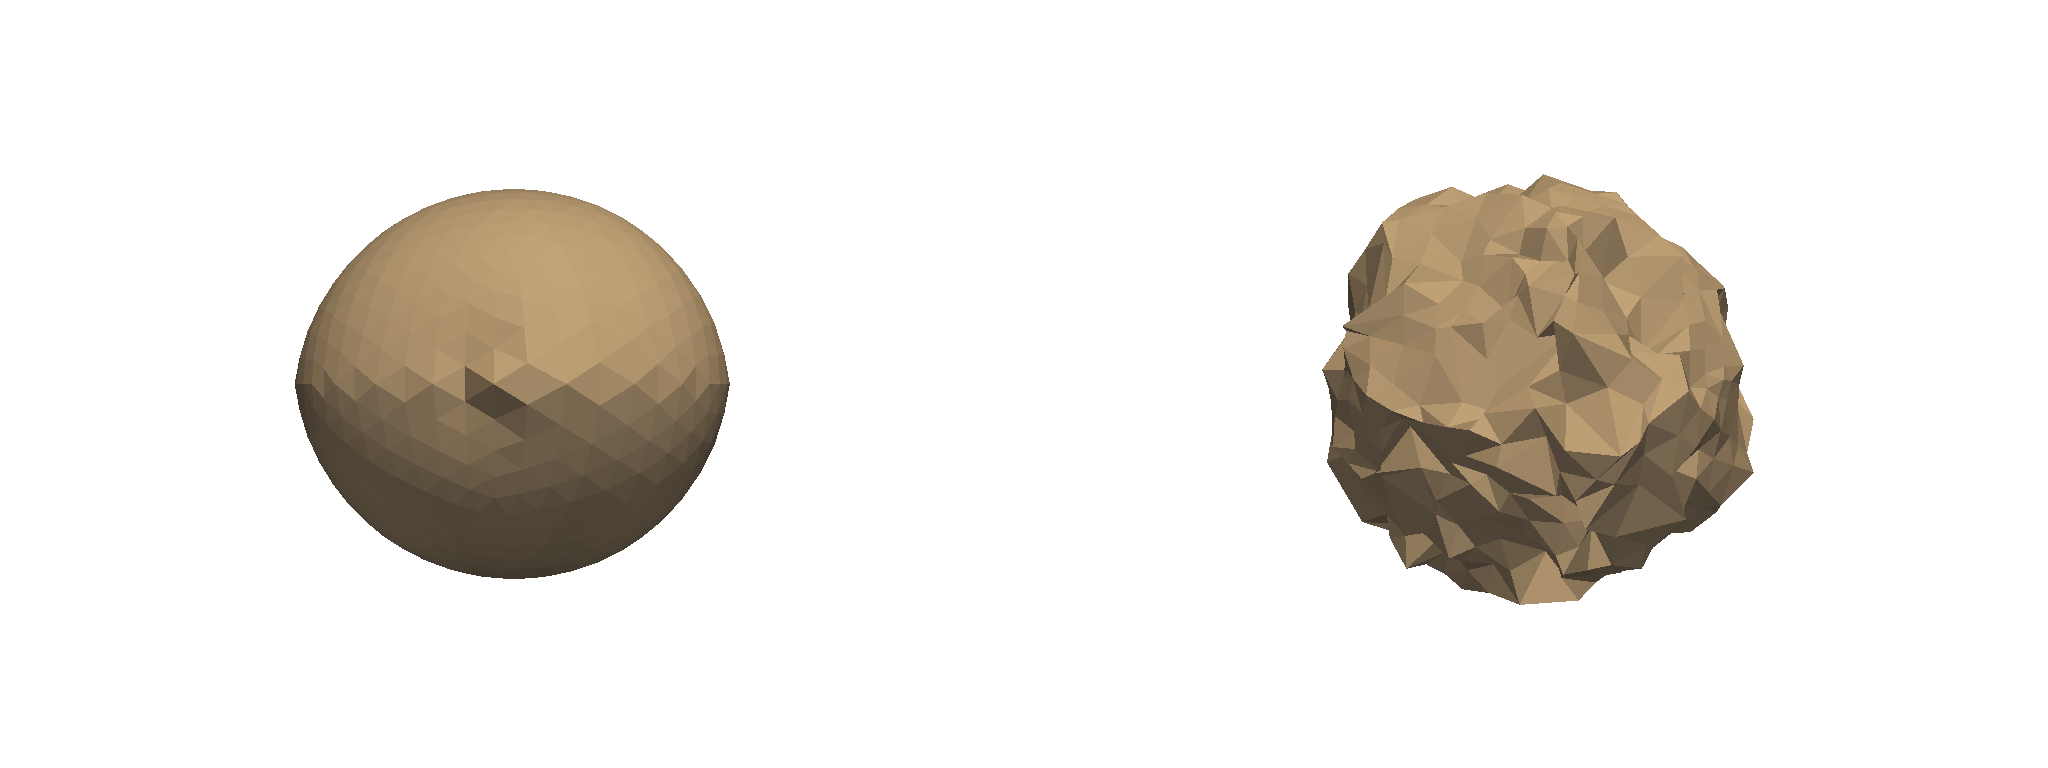

In [10]:
run_id_w = widgets.IntSlider(min=0, max=12)
interact(display_gif, i=run_id_w);

In [11]:
print(run_id_w.value)
tmp_model_path = client.download_artifacts(
    runs_df.run_id[run_id_w.value], 
    "model", 
    local_dir
)

0


In [12]:
model_path = os.path.join(tmp_model_path, "data/model.pth")

In [13]:
# torch.load(os.path.basename(model))
model = torch.load(model_path, map_location=torch.device('cpu'))

In [14]:
runs_df[runs_df.columns[runs_df.columns.str.startswith("params.dataset")]]

,params.dataset_freq_max,params.dataset_l_max,params.dataset_center_around_mean,params.dataset_random_seed,params.dataset_complexity,params.dataset_n_timeframes,params.dataset_resolution,params.dataset_type,params.dataset_template,params.dataset_max_static_amplitude,params.dataset_complexity_c,params.dataset_complexity_s,params.dataset_max_dynamic_amplitude
0,2,1,False,101,12,4,8,synthetic,icosphere,0.2,4,8,0.1
1,2,1,False,101,12,4,8,synthetic,icosphere,0.2,4,8,0.1
2,2,1,False,101,12,2,8,synthetic,icosphere,0.2,4,8,0.1
3,2,1,False,101,12,4,8,synthetic,icosphere,0.01,4,8,0.1
4,2,1,False,101,12,4,8,synthetic,icosphere,0.2,4,8,0.1
5,2,1,False,101,12,4,8,synthetic,icosphere,0.01,4,8,0.1
6,2,1,True,101,12,1,8,synthetic,icosphere,0.3,4,8,0.1
7,2,1,False,101,12,1,8,synthetic,icosphere,0.3,4,8,0.1
8,2,1,True,101,12,20,8,synthetic,icosphere,0.3,4,8,0.1
9,2,1,True,101,12,20,8,synthetic,icosphere,0.2,4,8,0.01


### Create (or retrieve) dataset

In [15]:
from data.synthetic.SyntheticMeshPopulation import SyntheticMeshPopulation
from data.SyntheticDataModules import SyntheticMeshesDataset
from torch.utils.data import DataLoader
from main import get_datamodule

Re-build configuration

In [16]:
runinfo = dict(runs_df.iloc[run_id_w.value])

dataset_params = {
    "N": 10,
    "amplitude_static_max": float(runinfo["params.dataset_max_static_amplitude"]),
    "amplitude_dynamic_max": float(runinfo["params.dataset_max_dynamic_amplitude"]),
    "T": int(runinfo["params.dataset_n_timeframes"]),
    "freq_max": int(runinfo["params.dataset_freq_max"]),
    "l_max": int(runinfo["params.dataset_l_max"]),
    "mesh_resolution": int(runinfo["params.dataset_resolution"]),
    "random_seed": runinfo["params.dataset_random_seed"]
}    

config = {
    "batch_size": 32,
    "parameters": dataset_params,
    "preprocessing": Namespace(**{ "center_around_mean": False })
}

config = Namespace(**config)

In [17]:
mesh_popu = SyntheticMeshesDataset(config.parameters, config.preprocessing)
meshes_loader = DataLoader(mesh_popu)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 233.06it/s]


Adapt model from PyTorch Geometric 2.0.3 to 2.0.4 (attribute `__explain__` changes to `_explain` producing an `AttributeError`)

In [18]:
def upgrade_pyg_model_203_to_204(model):
    
    for i, _ in enumerate(model.model.cheb_enc):
        model.model.cheb_enc[i]._explain = model.model.cheb_enc[i].__explain__
        
    for i, _ in enumerate(model.model.cheb_dec_c):
        model.model.cheb_dec_c[i]._explain = model.model.cheb_dec_c[i].__explain__
    
    for i, _ in enumerate(model.model.cheb_dec_s):
        model.model.cheb_dec_s[i]._explain = model.model.cheb_dec_s[i].__explain__
    
    model.model.pool._explain = model.model.pool.__explain__
    
    return model

In [19]:
model = upgrade_pyg_model_203_to_204(model)

In [20]:
def get_temporal_z(model, x):
    
    '''
    model: PyTorch Lightning Module.
    x: temporal sequence of meshes (point clouds)
    '''
    
    x = subject[0]

    self = model.model
    
    if self.phase_input:
        x = self.phase_tensor(x)
    
    n_timeframes = config.parameters["T"]
    x = x.reshape(1, n_timeframes, -1, 2*self.filters_enc[0])
        
    for i in range(self.n_layers):  
        x = self.cheb_enc[i](x, self.A_edge_index[i], self.A_norm[i])
        x = F.relu(x)
        x = self.pool(x, self.downsample_matrices[i])
        
    
    x = x.reshape(x.shape[0], self.n_timeframes, self._n_features_before_z)    
    mu_c, mu_s = [], []
    
    # Iterate through time points
    for i in range(n_timeframes):
        mu = self.enc_lin_mu(x[:,i,:])
        mu_c.append(mu[:,:self.z_c])
        mu_s.append(mu[:,self.z_c:])
        
    # convert list of 1D-tensors to 2D numpy.array
    z_c = np.array([kk.detach().numpy() for kk in mu_c])
    z_s = np.array([kk.detach().numpy() for kk in mu_s])
    
    return {"z_c": z_c, "z_s": z_s}

In [21]:
for subject in meshes_loader:
    break

In [22]:
x = subject[0]
z = get_temporal_z(model, x)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1284x6 and 3x128)

### Inspect intermediate layers with `surgeon_pytorch`

In [ ]:
model_wrapped = Inspect(model, layer={'layer1': 'x1', 'layer2': 'x2'})

In [31]:
get_layers(model)

['model',
 'model.cheb_enc',
 'model.cheb_enc.0',
 'model.cheb_enc.0.lins',
 'model.cheb_enc.0.lins.0',
 'model.cheb_enc.0.lins.1',
 'model.cheb_enc.0.lins.2',
 'model.cheb_enc.0.lins.3',
 'model.cheb_enc.0.lins.4',
 'model.cheb_enc.0.lins.5',
 'model.cheb_enc.1',
 'model.cheb_enc.1.lins',
 'model.cheb_enc.1.lins.0',
 'model.cheb_enc.1.lins.1',
 'model.cheb_enc.1.lins.2',
 'model.cheb_enc.1.lins.3',
 'model.cheb_enc.1.lins.4',
 'model.cheb_enc.1.lins.5',
 'model.cheb_enc.2',
 'model.cheb_enc.2.lins',
 'model.cheb_enc.2.lins.0',
 'model.cheb_enc.2.lins.1',
 'model.cheb_enc.2.lins.2',
 'model.cheb_enc.2.lins.3',
 'model.cheb_enc.2.lins.4',
 'model.cheb_enc.2.lins.5',
 'model.cheb_enc.3',
 'model.cheb_enc.3.lins',
 'model.cheb_enc.3.lins.0',
 'model.cheb_enc.3.lins.1',
 'model.cheb_enc.3.lins.2',
 'model.cheb_enc.3.lins.3',
 'model.cheb_enc.3.lins.4',
 'model.cheb_enc.3.lins.5',
 'model.cheb_dec_c',
 'model.cheb_dec_c.0',
 'model.cheb_dec_c.0.lins',
 'model.cheb_dec_c.0.lins.0',
 'model.c

#### 

In [ ]:
surgeon_pytorch.inspect.get_module(model, "model.cheb_enc")

In [29]:
surgeon_pytorch.inspect.get_module(model, "model.cheb_enc")

ModuleList(
  (0): ChebConv_Coma(3, 128, K=6, normalization=None)
  (1): ChebConv_Coma(128, 128, K=6, normalization=None)
  (2): ChebConv_Coma(128, 128, K=6, normalization=None)
  (3): ChebConv_Coma(128, 128, K=6, normalization=None)
)

In [25]:
def plot_z_vs_t(i):
    z_s = z["z_s"]
    plt.plot(z_s[:,0,i-1])
    plt.ylabel(f'z_{i}')
    plt.title("z(t) before temporal aggregation")
    plt.show()

interact(plot_z_vs_t, i=widgets.IntSlider(min=1, max=z["z_s"].shape[-1]));

NameError: name 'z' is not defined